# notes

* Harmful algae: Karenia Brevis
* K. brevis count (in cells per liter)
* References to K. brevis being present are represented by a cell count of 1 cell per liter
* Depth == depth of water sample
* data from [here](https://geodata.myfwc.com/datasets/dfd5e2914bd24944933650671cf86aa5_18?selectedAttribute=DEPTH)

In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bamboolib as bam
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.forecasting.naive import NaiveForecaster
# from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from pandas.tseries.offsets import DateOffset

In [2]:
df = pd.read_csv('../dat/Recent_Harmful_Algal_Bloom__HAB__Events.csv')

In [3]:
dfasdf = df.groupby(['LOCATION']).agg({col: ['size'] for col in df.columns})
dfasdf.columns = ['_'.join(multi_index) for multi_index in dfasdf.columns.ravel()]
dfasdf = dfasdf.reset_index()
dfasdf = dfasdf.sort_values(by=['X_size'], ascending=[False])
dfasdf

X          Y  OBJECTID             SAMPLE_DATE      TIME  \
0     -81.307700  29.869400    446382  2015/01/20 00:00:00+00  16:21:00   
1     -81.366900  30.051600    446383  2015/01/20 00:00:00+00  15:14:00   
2     -82.633400  27.800200    446384  2015/01/20 00:00:00+00       NaN   
3     -82.624800  27.782200    446385  2015/01/20 00:00:00+00       NaN   
4     -82.577900  27.331600    446386  2015/01/21 00:00:00+00  14:00:00   
...          ...        ...       ...                     ...       ...   
50805 -80.795517  28.623650    497187  2020/09/15 00:00:00+00  11:25:00   
50806 -80.739100  28.526410    497188  2020/09/15 00:00:00+00  11:50:00   
50807 -80.766533  28.475083    497189  2020/09/15 00:00:00+00  12:05:00   
50808 -80.662450  28.401700    497190  2020/09/15 00:00:00+00  12:25:00   
50809 -80.628440  28.357133    497191  2020/09/15 00:00:00+00  12:55:00   

      TIMEZONE  DEPTH                                       LOCATION  \
0          GMT    0.3               San Sebastian (Matanzas River)     
1          GMT    0.3           Pine Island; S of (Tolomato River)     
2          GMT    0.5  Coffee Pot Park Boat Ramp (Coffee Pot Bayou)    
3          GMT    0.5   North Shore Pool Beach (Middle Tampa Bay)      
4          GMT    0.5                      Bay Dock (Sarasota Bay)     
...        ...    ...                                            ...   
50805      EDT    0.2          Parrish Park Boat Ramp (Indian River)   
50806      EDT    0.2       NASA Causeway; SE side of (Indian River)   
50807      EDT    0.2         Port St. John Boat Ramp (Indian River)   
50808      EDT    0.2                      Kelly Park (Banana River)   
50809      EDT    0.2             520 Slick Boat Ramp (Banana River)   

        LATITUDE  LONGITUDE            NAME  COUNT_          HAB_ID  
0      29.869400 -81.307700  Karenia brevis       0  HABW150121-013  
1      30.051600 -81.366900  Karenia brevis       0  HABW150121-014  
2      27.800200 -82.633400  Karenia brevis       0  HABW150121-015  
3      27.782200 -82.624800  Karenia brevis       0  HABW150121-016  
4      27.331600 -82.577900  Karenia brevis       0  HABW150121-017  
...          ...        ...             ...     ...             ...  
50805  28.623650 -80.795517  Karenia brevis       0  HABW200916-001  
50806  28.526410 -80.739100  Karenia brevis       0  HABW200916-002  
50807  28.475083 -80.766533  Karenia brevis       0  HABW200916-003  
50808  28.401700 -80.662450  Karenia brevis       0  HABW200916-004  
50809  28.357133 -80.628440  Karenia brevis       0  HABW200916-005  

[50810 rows x 13 columns]

In [14]:
df['tformat'] = df['TIME'].fillna('00:00:00')
df['dt'] = list(map(lambda x, y: x[:10] + ' ' + y, df['SAMPLE_DATE'], df['tformat']))
df['dt'] = pd.to_datetime(df['dt'])

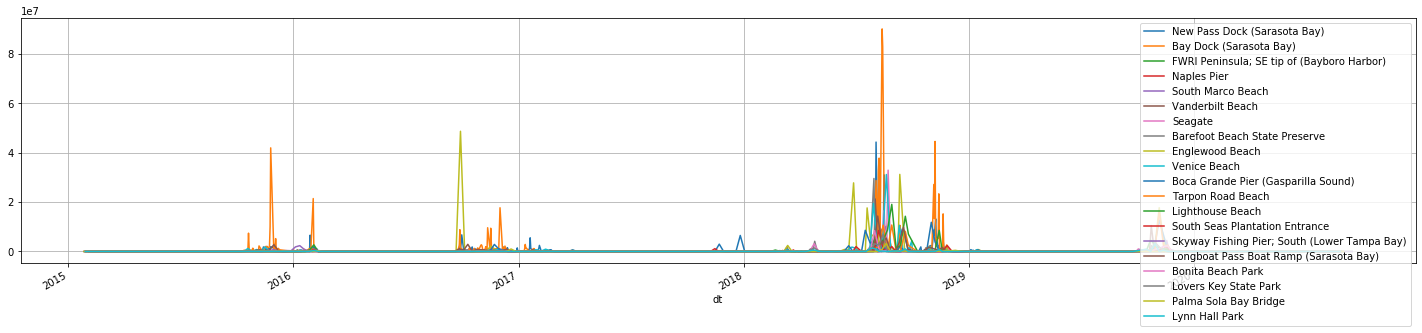

In [47]:
topsamplelocs = df.groupby('LOCATION').count().sort_values('X', ascending=False).head(20).index

fig, ax = plt.subplots(1, 1, figsize=(25,5), facecolor='white')

for location in topsamplelocs:
    df[df['LOCATION'] == location].set_index('dt')['COUNT_'].plot(ax=ax, label=location)

ax.legend()
ax.grid()
plt.show()

In [247]:
df['year'] = df['dt'].dt.year
df['month'] = df['dt'].dt.month
df['day'] = df['dt'].dt.day
df['hour'] = df['dt'].dt.hour

In [309]:
# dfml = df.copy(deep=True)

# lessthan100 = df.groupby('LOCATION').count()
# lessthan100 = lessthan100[lessthan100['X'] > 100].index
# dfml = df[df['LOCATION'].isin(lessthan100)]

dfml = df[df['LOCATION'] == 'New Pass Dock (Sarasota Bay)']
dfml.sort_values('dt', inplace=True)

In [310]:
X = dfml[['LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'hour']]
y = dfml[['COUNT_', 'dt']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

idx_train = y_train['dt']
idx_test  = y_test['dt']
y_train.drop('dt', inplace=True, axis=1)
y_test.drop('dt', inplace=True, axis=1)

rf = RandomForestRegressor(n_jobs=-1)

rf.fit(X_train, y_train)

print(r2_score(y_train, rf.predict(X_train)))
print(r2_score(y_test, rf.predict(X_test)))

0.8481765350747983
0.6290735791947423


In [229]:
X = dfml[['LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'hour']]
y = dfml[['COUNT_', 'dt']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

idx_train = y_train['dt']
idx_test  = y_test['dt']
y_train.drop('dt', inplace=True, axis=1)
y_test.drop('dt', inplace=True, axis=1)

lr = LinearRegression(n_jobs=-1)

lr.fit(X_train, y_train)

print(r2_score(y_train, lr.predict(X_train)))
print(r2_score(y_test, lr.predict(X_test)))

0.0033871505678044755
0.0042796909821068985


In [311]:
y_train['dt'] = idx_train
y_test['dt'] = idx_test

y_train.sort_values('dt', inplace=True)
y_test.sort_values('dt', inplace=True)

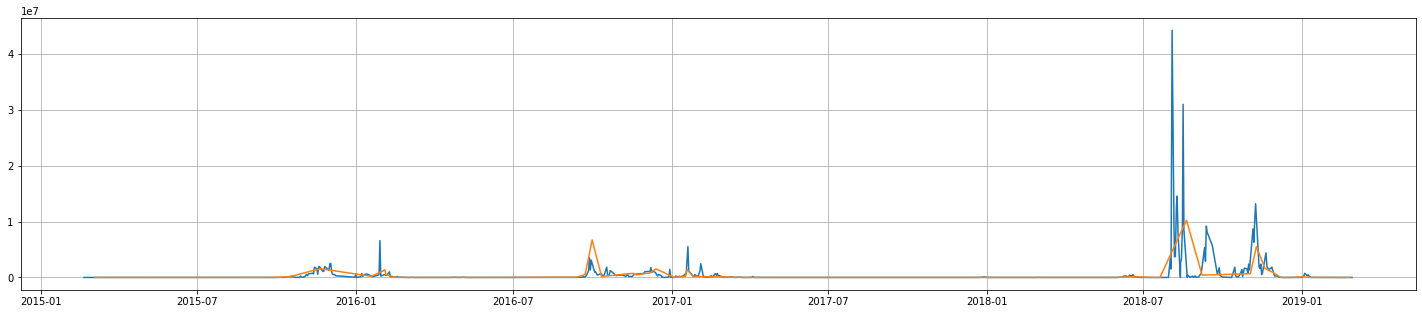

In [312]:
fig, ax = plt.subplots(1, 1, figsize=(25,5), facecolor='white')

ax.plot(y_train.set_index('dt'))
ax.plot(y_test.set_index('dt'))

ax.grid()
plt.show()

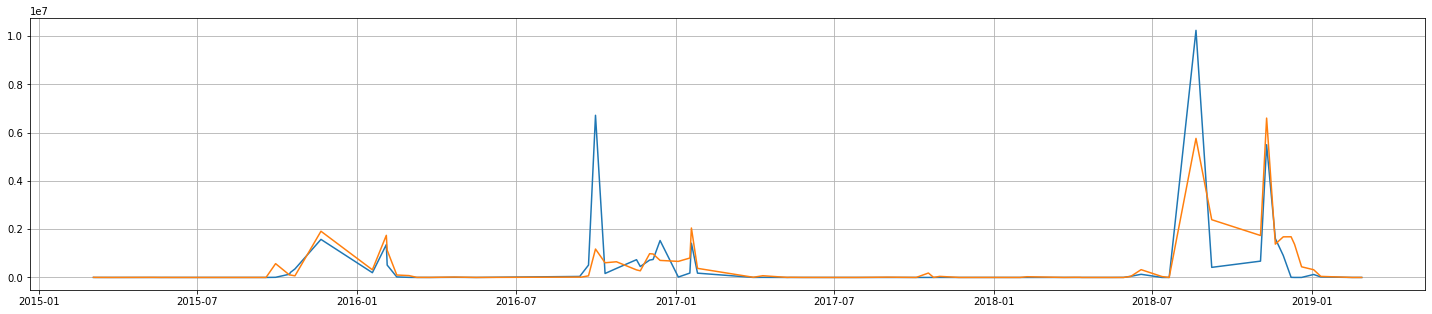

In [313]:
preds = pd.DataFrame({'COUNT_': rf.predict(X_test), 'dt': idx_test})
preds.sort_values('dt', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(25,5), facecolor='white')

ax.plot(y_test.set_index('dt'))
ax.plot(preds.set_index('dt'))

ax.grid()
plt.show()

In [314]:
X_testtest = X_test.copy(deep=True)
X_testtest['year'] = X_testtest['year'] + 2
X_testtest = X_testtest[X_testtest['year'] >= 2020]

In [315]:
X_test.shape

(87, 6)

In [316]:
X_testtest.shape

(32, 6)

In [317]:
def dater(year, month, day, hour):
    date = pd.to_datetime(year, format='%Y')
    date += DateOffset(months=month-1)
    date += DateOffset(days=day-1)
    date += DateOffset(hours=hour)
    
    return date

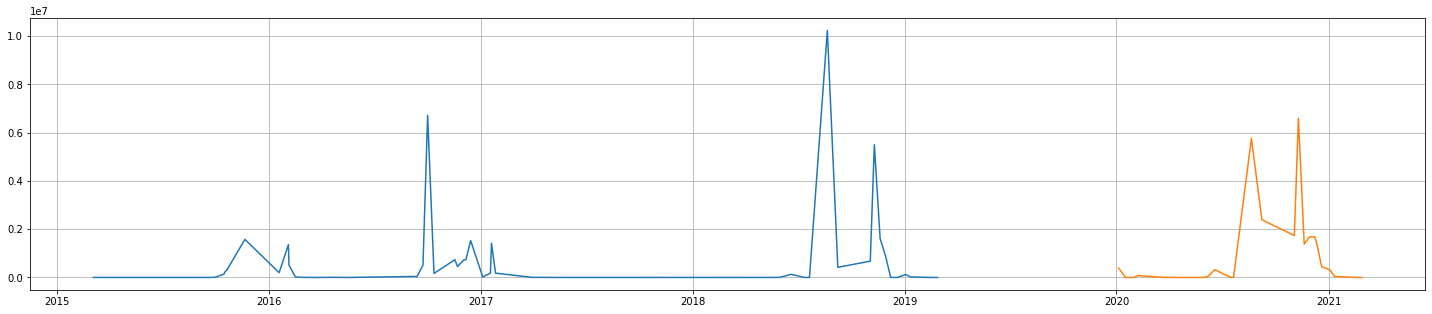

In [318]:
preds = pd.DataFrame({'COUNT_': rf.predict(X_testtest)})
preds['dt'] = list(map(dater, X_testtest['year'], X_testtest['month'], X_testtest['day'], X_testtest['hour']))
preds.sort_values('dt', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(25,5), facecolor='white')

ax.plot(y_test.set_index('dt'))
ax.plot(preds.set_index('dt'))

ax.grid()
plt.show()

# temporal methods

In [192]:
y = df[df['LOCATION'] == 'New Pass Dock (Sarasota Bay)'][['COUNT_', 'dt']]
y.sort_values('dt', inplace=True)
y.set_index('dt', inplace=True)
y = y.resample('H').mean()
y.fillna(0, inplace=True)

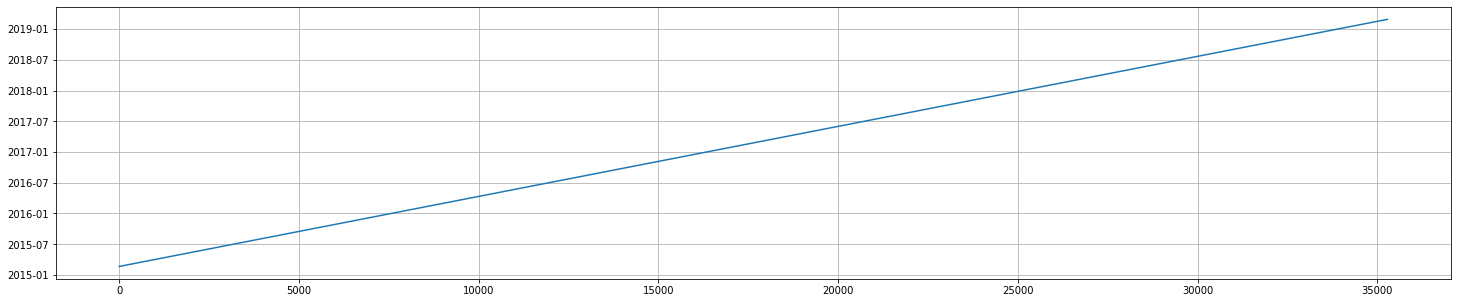

In [193]:
plt.figure(figsize=(25,5), facecolor='white')

plt.plot(y.index)

plt.grid()
plt.show()

In [194]:
y = y.iloc[:,0]

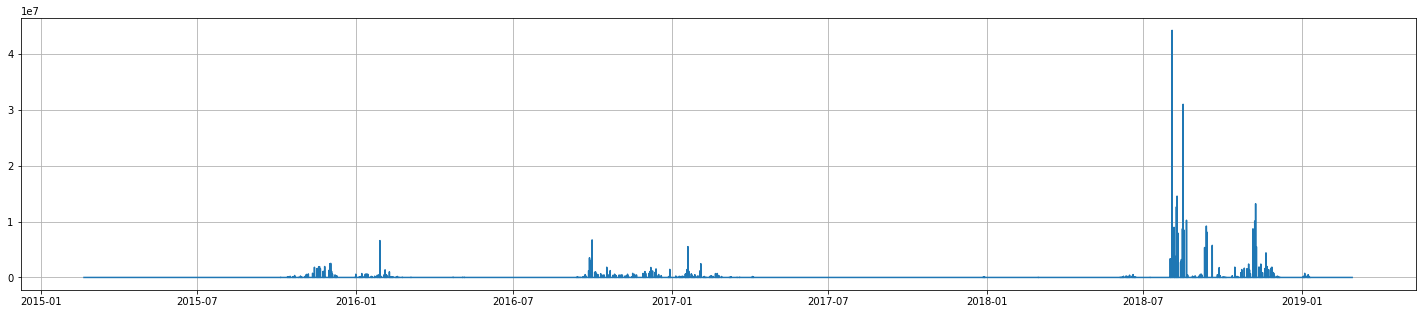

In [195]:
plt.figure(figsize=(25,5), facecolor='white')

plt.plot(y)

plt.grid()
plt.show()

In [198]:
# y_train, y_test = temporal_train_test_split(y)
y_train = y
fh = np.arange(1, 15000)
# forecaster = ThetaForecaster(sp=12)
# forecaster = NaiveForecaster()
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
# smape_loss(y_test, y_pred)

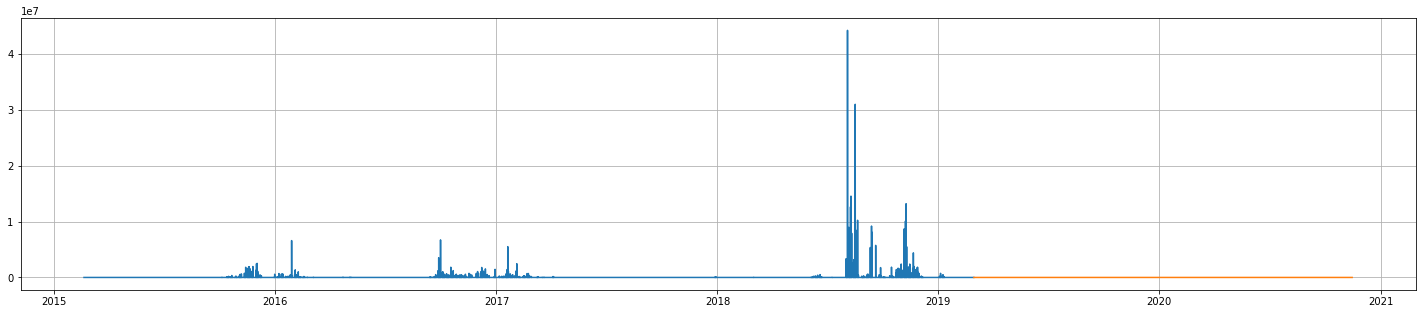

In [199]:
plt.figure(figsize=(25,5), facecolor='white')

plt.plot(y)
plt.plot(y_pred)

plt.grid()
plt.show()